# Twitter and Reddit Sentiment Analysis

---
The following notebook deals with text data acquired from twitter and reddit. All these Tweets and Comments were extracted using there Respective Apis Tweepy and PRAW.
These tweets and Comments Were Made on Narendra Modi and Other Leaders as well as Peoples Opinion Towards the Next Prime Minister of The Nation ( In Context with General Elections Held In India - 2019).
All the Tweets and Comments From twitter and Reddit are Cleaned using Pythons re and also NLP with a Sentimental Label to each ranging from -1 to 1.   

-1 -> Negative sentiment    
0 -> Neutral sentiment    
+1 -> Positive sentiment    
    
The data and more information about it can be found here: https://www.kaggle.com/cosmos98/twitter-and-reddit-sentimental-analysis-dataset    
All credit in regards to the aquisition of the data goes to to the original author of the above post. 

---

In [1]:
#Import Statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

from xgboost import XGBClassifier
from sklearn.svm import LinearSVC

## Data Acquisition

---
The first step is gathering the data into a singular dataset. We do this by first extracting the Twitter and Reddit data from their respective .csv files and placing them into dataframes. Then, we concatinate both those dataframes into one main dataframe.   

I've renamed the columns tited 'clean_comment' to 'text' to make the dataframe more intuitive and slightly easier to work with.

---

In [2]:
#Extract reddit data
reddit_data = pd.read_csv('../input/twitter-and-reddit-sentimental-analysis-dataset/Reddit_Data.csv')
reddit_data.rename(columns = {'clean_comment': 'text'}, inplace = True)

In [3]:
#Extract twitter data
twitter_data = pd.read_csv('../input/twitter-and-reddit-sentimental-analysis-dataset/Twitter_Data.csv')
twitter_data.rename(columns = {'clean_text': 'text'}, inplace = True)

In [4]:
reddit_data.head(), twitter_data.head()

(                                                text  category
 0   family mormon have never tried explain them t...         1
 1  buddhism has very much lot compatible with chr...         1
 2  seriously don say thing first all they won get...        -1
 3  what you have learned yours and only yours wha...         0
 4  for your own benefit you may want read living ...         1,
                                                 text  category
 0  when modi promised “minimum government maximum...      -1.0
 1  talk all the nonsense and continue all the dra...       0.0
 2  what did just say vote for modi  welcome bjp t...       1.0
 3  asking his supporters prefix chowkidar their n...       1.0
 4  answer who among these the most powerful world...       1.0)

In [5]:
#Combine both dataframes into one master dataframe
data = pd.concat([reddit_data, twitter_data], ignore_index = True)

## Data Cleaning

---
Before working with the data, we must first clean it. This includes removing all the null data. With NLP, we also need to lemmatize the data and remove stopwords and punctuations so that our model performs better. We do this as well as tokenize the data in the modelling section with the function 'data_cleaning_tokenizer'

---

In [6]:
#Check for any null values
data.isna().sum()

text        104
category      7
dtype: int64

In [7]:
#Drop rows with null values
data.dropna(axis = 0, inplace = True)

In [8]:
#Check for any null values
data.isna().sum()

text        0
category    0
dtype: int64

In [9]:
#Checking the shape of the data to ensure nothing is broken
data.shape

(200118, 2)

In [10]:
#Getting Stopwords
from spacy.lang.en.stop_words import STOP_WORDS
stopwords = list(STOP_WORDS)

#Getting a list of punctuations
from string import punctuation
punct = list(punctuation)

print("Length of punctuations:\t {} \nLength of stopwords:\t {}".format(len(punct), len(stopwords)))

Length of punctuations:	 32 
Length of stopwords:	 326


## Data Visualization

---
In order to better understand our data, we visualize it. Our main point of interest is to note how the sentiments are distributed and weather any of the categories are skewed.

Since the data isnt skewed, we can proceed normally with our classification. Note, however, that there is approximately twice as much data with positive sentiment than there is with negative sentiment. 

---

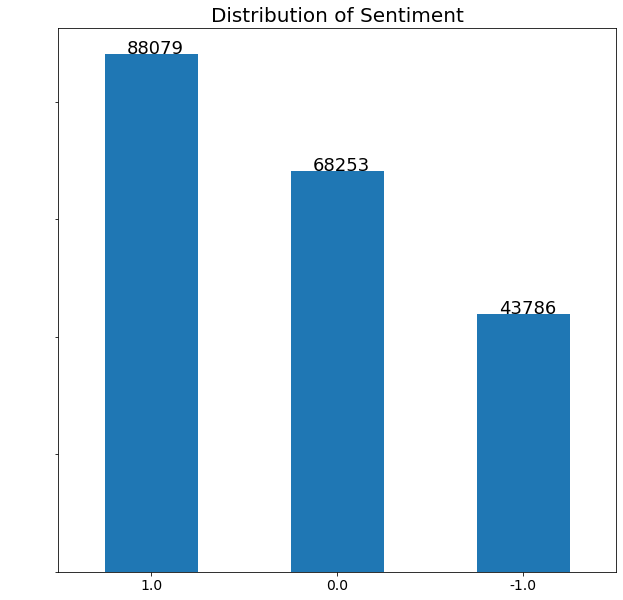

In [11]:
fig , ax = plt.subplots(figsize = (10,10))
ax = data['category'].value_counts().plot(kind = 'bar')

plt.xticks(rotation = 0, size = 14)
plt.yticks(size = 14, color = 'white')
plt.title('Distribution of Sentiment', size = 20)

ax.annotate(text = data['category'].value_counts().values[0], xy = (-0.13,88079), size = 18)
ax.annotate(text = data['category'].value_counts().values[1], xy = (0.87,68253), size = 18)
ax.annotate(text = data['category'].value_counts().values[2], xy = (1.87,43786), size = 18)

plt.show()

## Modelling: TF-IDF and LinearSVM

---
In addition to tokenizing our data, the function 'data_cleaning_tokenizer' also removes stop words, converts all the data to lower and lemmatizes all the data.    

The vectorization of our data is done in the TF-IDF format through TfidfVectorizer().    

After our data is vectorized, it is read to be used in a model. We use LinearSVM in this case beacuse of its effectiveness and ease of implementation. 

---

In [12]:
#Load spacy model
nlp = spacy.load('en_core_web_sm')

In [13]:
#Define function to find and drop blank entries in dataframe
def drop_blank(dataframe, column):
    blank_index = dataframe[dataframe[column] == ''].index
    dataframe.drop(blank_index, inplace = True)
    dataframe.reset_index(inplace = True, drop = True)
    
    return dataframe

In [14]:
def data_cleaning_tokenizer(sentence):
    """
    This function cleans up a sentence. It first tokenizes it, removes stopewords, and then performs lemmatization on the sentence. 
    The function returns a list of tokenized words so that it can be converted into a doc vector directly. 
    """
    
    doc = nlp(sentence)
    tokens = []
    
    #Creates a list of lemmatized tokens
    for token in doc:
        try:
            temp = token.lemma_.lower().strip()
            
        except:
            temp = token.lower_
            
        tokens.append(temp)
        
    cleaned_tokens = []
    
    #Removes stopwords and punctuations
    for token in tokens:
        if token not in stopwords and token not in punct:
            cleaned_tokens.append(token)
        
    #cleaned_tokens = " ".join(cleaned_tokens)
    
    return cleaned_tokens

In [15]:
#Getting X and y
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(tokenizer=data_cleaning_tokenizer)
X = vectorizer.fit_transform(data['text'])
y = data.category

#Splitting the data into training and testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.1)

In [16]:
#Creating, fitting and scoring classifier
classifier = LinearSVC()
classifier.fit(X_train, y_train)
print(f"Accuracy: {classifier.score(X_test, y_test) * 100:.3f}%", )

Accuracy: 81.881%


---

We achieved 81% accuracy on our model. This is not bad, but it can be imporoved upon. The most efficient way to imporove our accuracy would be to implement an LSTM model. Neural networks often achieve over 90% on datasets like these.

References:    
- https://www.kaggle.com/kritanjalijain/twitter-sentiment-analysis-lstm
- https://www.youtube.com/watch?v=cd51nXNpiiU

Thankyou for going through my notebook! Please comment if you have any questions or suggestions!

---